In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Lendo e tratando dados

In [7]:
def process_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    return img_array

In [8]:
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img_binary = process_image(img_path)
            images.append(img_binary.flatten())
    return images

In [9]:
def load_strings_from_folder(folder_path):
    strings = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    content = file.read().strip()
                    strings.append(content)
                    filenames.append(filename)
            except Exception as e:
                print(f"Erro ao ler o arquivo {file_path}: {e}")
    return strings, filenames

In [10]:
treinamento = load_images_from_folder('dados/CAPTCHA-10k/treinamento')
treinamento = np.array(treinamento)
validacao = load_images_from_folder('dados/CAPTCHA-10k/validacao')
validacao = np.array(validacao)
teste = load_images_from_folder('dados/CAPTCHA-10k/teste')
teste = np.array(teste)
labels = load_strings_from_folder('dados/CAPTCHA-10k/labels10k')[0]

In [11]:
treino_x = treinamento
treino_y = labels[:8000]

validacao_x = validacao
validacao_y = labels[8000:9000]

teste_x = teste
teste_y = labels[9000:]

In [12]:
def print_img(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

In [13]:
def apply_unsharp_mask(image, kernel_size=(5, 5), sigma=1.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 6,-1],
                       [0, -1, 0]])
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.filter2D(blurred, -1, kernel)
    
    return sharpened

In [14]:
def particionar_img(image_array):
    image_array = np.reshape(image_array, (50, 180))
    # print_img(image_array)
    particoes = []
    offset = 30
    for i in range(0, 6):
        particao = image_array[10: 46, 5+offset*i:45+offset*i]
        particao = apply_unsharp_mask(particao)
        particoes.append(particao)
        # print_img(particao)
    particoes[5] = np.pad(particoes[5], ((0, 0), (7, 8)), 'constant', constant_values=255)
    return particoes

In [15]:
def aplicar_particao(images):
    images_particionadas = []
    for i in range(len(images)):
        images_particionadas.extend(particionar_img(images[i]))
    return np.array(images_particionadas)

In [16]:
def particonar_strings(strings):
    strings_particionadas = []
    for i in range(0, len(strings)):
        for j in range(0, 6):
            strings_particionadas.append(strings[i][j])
    
    return np.array(strings_particionadas)

In [17]:
set_caracteres = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?',
                  'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(set_caracteres)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

char_to_int = dict((c, i) for i, c in enumerate(set_caracteres))
int_to_char = dict((i, c) for i, c in enumerate(set_caracteres))

In [18]:
X_train = aplicar_particao(treino_x)
X_test = aplicar_particao(teste_x)
X_val = aplicar_particao(validacao_x)

y_train = particonar_strings(treino_y)
y_test = particonar_strings(teste_y)
y_val = particonar_strings(validacao_y)

In [19]:
y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)
y_val_int = label_encoder.transform(y_val)

y_train_onehot = onehot_encoder.transform(y_train_int.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_int.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val_int.reshape(-1, 1))

# HOG

In [20]:
def extract_hog_features(images):
    hog_features = []
    for image in images:    
        fd = hog(image, orientations=12, pixels_per_cell=(6, 5), cells_per_block=(2, 2))
        hog_features.append(fd)
    return np.array(hog_features)

In [22]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)
X_val_hog = extract_hog_features(X_val)

## Classificador SVM

In [23]:
model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train_hog, y_train_int)

SVC(kernel='linear')

In [24]:
y_pred_svm = model_svm.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test_int, y_pred_svm))

accuracy_vector_svm = (y_pred_svm == y_test_int).astype(int)


Accuracy: 0.936


## Classificador NN

In [27]:
input_shape = (1680,) 

model_nn = Sequential()
model_nn.add(Flatten(input_shape=input_shape))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(37, activation='softmax'))
model_nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [28]:
model_nn.fit(X_train_hog, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val_hog, y_val_onehot))

Epoch 1/10
1500/1500 [==============================] - 10s 5ms/step - loss: 0.7142 - accuracy: 0.7936 - val_loss: 0.2563 - val_accuracy: 0.9275
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3324 - accuracy: 0.8994 - val_loss: 0.2273 - val_accuracy: 0.9322
Epoch 3/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2739 - accuracy: 0.9164 - val_loss: 0.2035 - val_accuracy: 0.9397
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2431 - accuracy: 0.9242 - val_loss: 0.2067 - val_accuracy: 0.9410
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2158 - accuracy: 0.9334 - val_loss: 0.1990 - val_accuracy: 0.9412
Epoch 6/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1996 - accuracy: 0.9378 - val_loss: 0.2115 - val_accuracy: 0.9395
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1847 - accuracy: 0.9413 - val_loss: 0.2153 - val_accuracy

In [29]:
y_pred_nn = model_nn.predict(X_test_hog)
y_pred_classes_nn = np.argmax(y_pred_nn, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy_vector_nn = (y_pred_classes_nn == y_true).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred_classes_nn))

188/188 [==============================] - 1s 3ms/step
Accuracy: 0.945


# CNN

In [ ]:
input_shape = (36, 40, 1)
num_classes = 37

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=64, validation_data=(X_val, y_val_onehot))

In [ ]:
y_pred_cnn = model.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy_vector_cnn = (y_pred_classes_cnn == y_true).astype(int)

print("Accuracy:", accuracy_score(y_true, y_pred_classes_cnn))

# Avaliando modelos

In [30]:
def gerar_freq(accuracy_vector):
    caracteres_reconhecidos = np.zeros(7)
    for i in range(0, 1000):
        soma = 0
        for j in range(0, 6):
            if accuracy_vector[i * 6 + j] == 1:
                soma += 1
        
        caracteres_reconhecidos[soma] += 1

    frequencias = np.zeros(7)
    for i in range(0, 7):
        frequencia = 0
        for j in range(i, 7):
            frequencia += caracteres_reconhecidos[j]
        frequencias[i] = frequencia
    frequencias = frequencias/1000

    return frequencias

In [31]:
def print_grafico(frequencias):
    x_values = [0, 1, 2, 3, 4, 5, 6]
    plt.figure(figsize=(10, 5))
    plt.plot(x_values, frequencias)

    plt.title('Resultado')
    plt.xlabel('Número mínimo de caracteres reconhecidos por captcha')
    plt.ylabel('Taxa de Reconhecimento')
    plt.ylim(0, 1.1)
    plt.grid(True)

    plt.show()

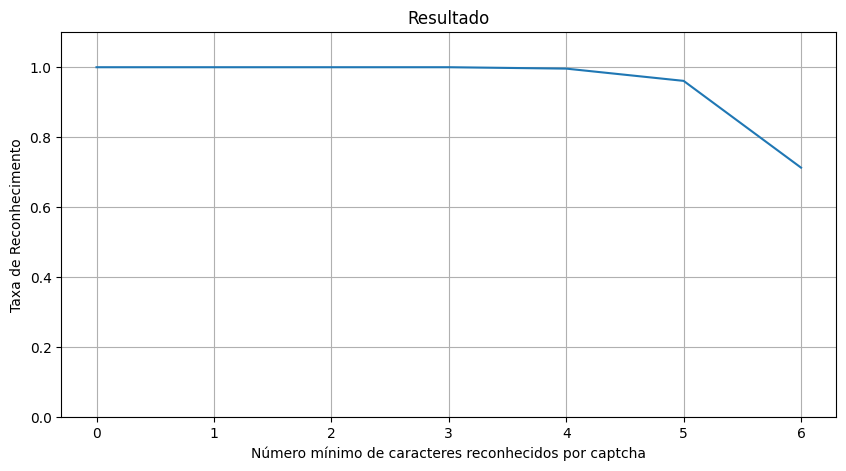

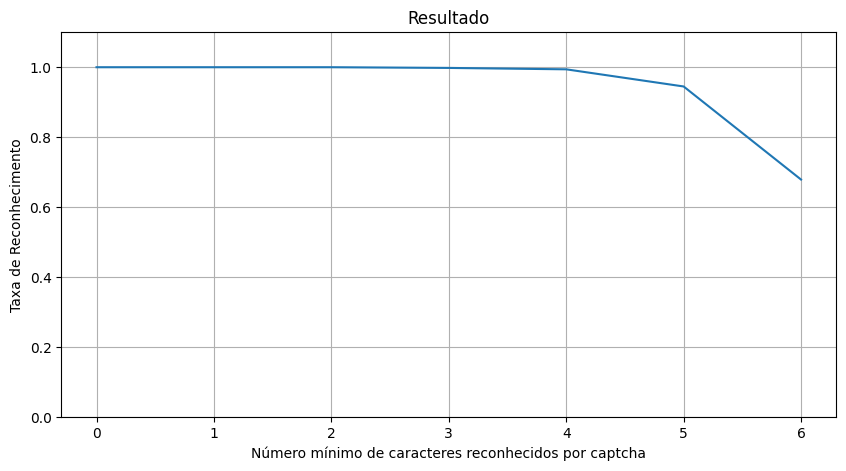

In [32]:
freq_cnn = gerar_freq(accuracy_vector_cnn)
freq_nn = gerar_freq(accuracy_vector_nn)
freq_svm = gerar_freq(accuracy_vector_svm)

print_grafico(freq_cnn)
print_grafico(freq_nn)
print_grafico(freq_svm)